In [288]:
import numpy as np
from scipy.integrate import odeint
import dill
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import math
import plotly.graph_objects as go

In [289]:
EXTRA_SMALL_SIZE = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rcParams['lines.linewidth'] = 2.5

In [290]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [291]:
# ---------- CONSTANTS -------------- #

In [292]:
GAMMA = 1/14
SIGMA = 1/5
STRENGTHS = np.arange(0.25, 1.01, 0.25)

In [293]:
# ---------- CONSTANTS -------------- #

In [294]:
# ---------- MODEL -------------- #

In [295]:
def delta_flight_seir(x, t, params, n, exp_in, exp_out, min_t, max_t):
    s, e, i, r = x
    beta, sigma, gamma = params
    t = min(max(min_t, t), max_t)
    in_e = exp_in(t) / n
    out_e = exp_out(t) / n
    ds = - beta * s * i 
    de = beta * s * i + in_e - min(sigma * e + out_e, e)
    di = sigma * e - min(gamma * i, i) 
    dr = gamma * i
    return [ds, de, di, dr]

In [296]:
FLIGHT_SEIR = delta_flight_seir

In [297]:
# ---------- MODEL -------------- #

In [298]:
# ---------- UTILS -------------- #

In [299]:
def to_date_str(date):
    return np.datetime_as_string(date, unit='D')

In [300]:
def to_plt_date(date_str):
    return matplotlib.dates.date2num(date.fromisoformat(date_str))

In [301]:
def get_date_range(dates, start_date, end_date):
    return dates[(dates >= start_date) & (dates <= end_date)]

In [302]:
def to_idx(dates, date):
    return np.argwhere(dates == date)[0][0]

In [303]:
#Assumption: E = I/ 2.5
def get_seir_by_date(df_target, date):
    df_by_date = df_target[df_target.index == date].iloc[0]
    seir = np.zeros(shape=4)
    seir[1] = df_by_date['i'] / 2.75
    seir[2] = df_by_date['i']
    seir[3] = df_by_date['r']
    seir[0] = 1 - seir[1] - seir[2] - seir[3]
    return seir

In [304]:
def find_best_R0(true_y, pred_y, R0_range):
    losses = np.zeros(len(R0_range))
    for idx, _ in enumerate(R0_range):
        losses[idx] = mean_squared_error(true_y, pred_y[idx, :])   
    return np.argmin(losses)

In [305]:
def get_real_strength(f_in, f_out, dates, reopen_date):
    f = f_in + f_out
    reopen_date_idx = to_idx(dates, reopen_date)
    jan_indices = []
    for date_idx, date in enumerate(dates):
        if(date.month == 1):
            jan_indices.append(date_idx)
    return  np.mean(np.sum(f[reopen_date_idx:, :], axis=1)) / np.mean(np.sum(f[jan_indices, :], axis=1))

In [306]:
def run_sim(data, start_date, end_date, R0_range, exp_in, exp_out, min_t, max_t, dates, seir_0=None):
    if seir_0 is None:
        seir_0 = get_seir_by_date(data.df_target, start_date)
    betas = np.array([r0 * GAMMA for r0 in R0_range])
    date_range = get_date_range(dates, start_date, end_date)
    seirs = np.zeros(shape=(len(betas), len(date_range), 4))
    for idx, beta in enumerate(betas):
        params = beta, SIGMA, GAMMA
        seirs[idx] = odeint(FLIGHT_SEIR, y0=seir_0, t=date_range.dayofyear, rtol=1e-8, args=(params, data.n, exp_in, exp_out, min_t, max_t))
    return date_range, seirs

In [307]:
# ---------- UTILS -------------- #

In [308]:
# ---------- PLOTS -------------- #

In [309]:
def plot_line_graph(x, y, labels, title, filename):
    plt.figure(figsize=(16, 8))
    df = pd.DataFrame(y.transpose(), x, labels)
    blues = sns.color_palette("Blues_d", n_colors=len(labels))
    blues.reverse()
    ax = sns.lineplot(data=df, palette=blues)
    for idx, label in enumerate(labels):
        ax.annotate(int(y[idx, -1]), (x[-2], y[idx, -1]))
    ax.set_xlabel('Date')
    ax.set_ylabel('Population (log)')
    ax.set_yscale('log')
    ax.xaxis.set_tick_params(rotation=15)
    plt.legend()
#     plt.title(title)
    plt.savefig(filename, bbox_inches='tight')

In [310]:
def plot_fit_R0(x, y, labels, target, best_idx):
    fig = plt.figure(facecolor='w', figsize=(16, 8))
    ax = fig.add_subplot(111)
    plt_dates = matplotlib.dates.date2num(x.to_pydatetime())
    line = None
    for idx, label in enumerate(labels[0:-1]):
        if idx == best_idx:
            continue
        line = ax.plot_date(plt_dates, y[idx] * 100, '-', c='C3', alpha=0.1, zorder=0)
    line[0].set_label('FlightSEIR R0 Range: [%0.2f, %0.2f]' % (labels[0], labels[-1]))
    ax.plot_date(plt_dates, y[best_idx] * 100,'-', c='C1', label='Best Fit {:.2f}'.format(labels[best_idx]))
    ax.plot_date(plt_dates, y[-1] * 100,'x', c='C1', label='Data')
    ax.set_xlabel('Date')
    ax.set_ylabel('Infected, %')
    ax.xaxis.set_tick_params(rotation=15)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.legend()
#     plt.title("Reopen R0 Estimation: %s" % target)
    plt.savefig('../graphs/covid/reopen_prediction0_%s.png' % target, bbox_inches='tight')

In [311]:
def plot_reopen_simulation(x_fit, y_fit, x_pred, y_pred, y_pred_labels, x_true, y_true, target, reopen_date, end_date, policy):
    fig = plt.figure(facecolor='w', figsize=(16, 8))
    ax = fig.add_subplot(111)
    
    df1 = pd.DataFrame(np.transpose(y_pred) * 100, x_pred, y_pred_labels)
    df2 = pd.DataFrame(np.transpose(y_fit) * 100, x_fit, ["Fit Real Air Traffic"])
    df3 = pd.DataFrame(np.transpose(y_true) * 100, x_true, ["Data"])
    
    blues = sns.color_palette("Blues_d", n_colors=len(y_pred_labels))
    blues.reverse()
    sns.lineplot(data=df1, palette=blues)
    sns.lineplot(data=df2, palette=sns.color_palette("Purples", 1))
    sns.scatterplot(data=df3, palette=sns.color_palette("Purples_d", 1), markers=['X'])
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Infected, %')
    ax.xaxis.set_tick_params(rotation=15)
    reopen_date_str = to_date_str(reopen_date)
    plt.axvline(x=to_plt_date(reopen_date_str), ls='--', label='Reopen date: ' + reopen_date_str, c='red')
    plt.legend()
#     plt.title("Reopen Simulation: %s, Reopen %s on %s, End on %s" % (target, policy, reopen_date, end_date))
    plt.savefig('../graphs/covid/reopen_prediction1_%s_%s_%s_%s.png' % (target, reopen_date, end_date, policy), bbox_inches='tight')

In [312]:
def plot_cumulative_infection(x, y, labels, target, reopen_date, end_date, policy):
    title = "Cumulative Infections: %s, Reopen %s on %s, End on %s" % (target, policy, reopen_date, end_date)
    filename = '../graphs/covid/reopen_prediction2_%s_%s_%s_%s.png' % (target, reopen_date, end_date, policy)
    plot_line_graph(x, y, labels, title, filename)

In [313]:
def plot_daily_infections(x, y, labels, target, reopen_date, end_date, policy):
    title = "Daily Infections: %s, Reopen %s on %s, End on %s" % (target, policy, reopen_date, end_date)
    filename = '../graphs/covid/reopen_prediction3_%s_%s_%s_%s.png' % (target, reopen_date, end_date, policy)
    plot_line_graph(x, y, labels, title, filename)

In [314]:
def plot_daily_infections_composition(x, daily_infections, exposed, subtitles, target, reopen_date, end_date, policy):
    fig = plt.figure(facecolor='w', figsize=(24, 16))
    plt_dates = matplotlib.dates.date2num(x.to_pydatetime())
    y_lim = math.ceil(np.max(daily_infections) / 100.0) * 100
    for idx, strength in enumerate(range(daily_infections.shape[0])):
        ax = fig.add_subplot(2, 2, idx + 1)
        ax.bar(plt_dates, exposed[idx, :], label="Imported Cases")
        ax.bar(plt_dates, daily_infections[idx, :] - exposed[idx, :], bottom=exposed[idx, :], label="Community Transmission")
#         ax.set_xlabel('Date')
#         ax.set_ylabel('Population')
        ax.xaxis_date()
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, 7))
        ax.xaxis.set_tick_params(rotation=10)
        ax.set_ylim([0, y_lim])
        legend = ax.legend(loc=2, prop={'size': 24}, framealpha=0.5)
        plt.xticks(fontsize= 20)
        plt.yticks(fontsize= 20)
        plt.title(subtitles[idx], fontsize= 24)
#     plt.suptitle("Daily Infections by Category: %s, Reopen %s on %s, End on %s" % (target, policy, reopen_date, end_date), fontsize=20)
    plt.savefig('../graphs/covid/reopen_prediction4_%s_%s_%s_%s.png' % (target, reopen_date, end_date, policy), bbox_inches='tight')

In [315]:
def show_table_cumulative(y):
    print(y.shape)
    fig = go.Figure(data=[go.Table(
        header=dict(values=['Strength', 'Cumulative Infections 1', 'Cumulative Infections 2', 'Cumulative Infections Diff']),
        cells=dict(values=[STRENGTHS, y[:, 0], y[:, -1], y[:, -1] - y[0, -1]]))])
    fig.update_layout(
        autosize=False,
        width=1000,
        height=200,
        margin=dict(l=20, r=20, t=40, b=20),
        title=dict(text="cumulative")
    )
    fig.show()

In [316]:
def show_table_by_composition(date_idx, exposed, daily_infections, title):
    imp = exposed[:, date_idx]
    total = daily_infections[:, date_idx]
    fig = go.Figure(data=[go.Table(
        header=dict(values=['Strength', 'Imported', 'Community Transmission', 'Total', 'Imported/Community Transmission']),
        cells=dict(values=[STRENGTHS, imp, total - imp, total, imp/(total - imp)]))])
    fig.update_layout(
        autosize=False,
        width=1000,
        height=200,
        margin=dict(l=20, r=20, t=40, b=20),
        title=dict(text=title)
    )
    fig.show()

In [317]:
# ---------- PLOT -------------- #

In [318]:
class ReopenSimulation():
    
    
    def __init__(self, target, policy, start_date, end_date):
        self.target = target
        self.policy = policy
        self.start_date = start_date
        self.end_date = end_date
        self.data = self.__load_data()
        self.dates = pd.date_range(self.data.dates[0], end_date)
        
        
    def __load_data(self):
        file_path = '../states/%s_data.pkl' % (self.target)
        with open(file_path, "rb") as file:
            return dill.load(file)
        
    def __load_mocks(self, reopen_date):
        file_path = '../states/%s_reopen_%s_%s.pkl' % (self.target, reopen_date, self.policy)
        with open(file_path, "rb") as file:
            return dill.load(file)
        
    def fit_and_run(self, R0_range, reopen_date):
        R0, seirs = self.fit(R0_range)
        self.run(R0, seirs, reopen_date)
        
         
    #Assumption: for early time R0 estimation, start after 2020-04-22
    def fit(self, R0_range):
        df_target = self.data.df_target
        
        x, seirs = run_sim(self.data, self.start_date, self.data.dates[-1], R0_range, self.data.exp_in, self.data.exp_out, self.data.min_t, self.data.max_t, self.data.dates)
        pred_y = seirs[:, :, 2]
        true_y = df_target[df_target.index.isin(x)]['i'].to_numpy()
        y = np.concatenate((pred_y, true_y.reshape((1, len(true_y)))), axis=0)
        
        start_idx = max(0, pd.to_datetime('2020-04-22').dayofyear - pd.to_datetime(start_date).dayofyear)
        best_idx = find_best_R0(true_y[start_idx:], pred_y[:, start_idx:], R0_range)
        plot_fit_R0(x, y, R0_range, self.target, best_idx)
        
        return R0_range[best_idx], seirs[best_idx]
        
    
    def run(self, R0, seirs, reopen_date):
        n = self.data.n
        df_target = self.data.df_target
        
        x_true = get_date_range(self.data.dates, self.start_date, self.data.dates[-1])
        y_true_i = df_target[df_target.index.isin(x_true)]['i'].to_numpy()
        y_true_r = df_target[df_target.index.isin(x_true)]['r'].to_numpy()[to_idx(x_true, reopen_date): ]
        x_pred = get_date_range(self.dates, reopen_date, self.end_date)
        y_pred, y_pred_labels, exposed = self.__pred(x_pred, R0, seirs, reopen_date)
        x_fit = get_date_range(self.data.dates, self.start_date, self.data.dates[-1])
        y_fit = seirs[:, 2]
        plot_reopen_simulation(x_fit, y_fit, x_pred, y_pred[:, :, 2], y_pred_labels, x_true, y_true_i, self.target, reopen_date, self.end_date, self.policy)

        cumulative = np.zeros(shape=(len(STRENGTHS), len(x_pred)))
        for idx, _ in enumerate(STRENGTHS):
            cumulative[idx] = np.cumsum(y_pred[idx, :, 2]) * n
        plot_cumulative_infection(x_pred, cumulative, y_pred_labels, self.target, reopen_date, self.end_date, self.policy)    
        show_table_cumulative(cumulative)
        daily_infections =  np.zeros(shape=(len(STRENGTHS), len(x_pred)))
        for idx, _ in enumerate(STRENGTHS):
            daily_infections[idx] = y_pred[idx, :, 2] * n
        plot_daily_infections(x_pred, daily_infections, y_pred_labels, self.target, reopen_date, self.end_date, self.policy)
        plot_daily_infections_composition(x_pred, daily_infections, exposed, y_pred_labels, self.target, reopen_date, self.end_date, self.policy)
        show_table_by_composition(to_idx(x_pred, reopen_date), exposed, daily_infections, "reopen date")
        show_table_by_composition(to_idx(x_pred, self.end_date), exposed, daily_infections, "end date")
        
            
    def __pred(self, x_pred, R0, seirs, reopen_date):
        mocks = self.__load_mocks(reopen_date)
        reopen_day_seir = seirs[self.__reopen_date_idx(reopen_date), :]
        y_pred = np.zeros(shape=(len(STRENGTHS), len(x_pred), 4))
        y_pred_labels = []
        exposed = np.zeros(shape=(len(STRENGTHS), len(x_pred)))
        for idx, strength in enumerate(STRENGTHS):
            exp_in = mocks.exposed_in[idx]
            exp_out = mocks.exposed_out[idx]
            y_pred_labels.append("{:.2f}% Air Traffic".format(strength * 100))
            _, seirs = run_sim(self.data, reopen_date, self.end_date, [R0], exp_in, exp_out, self.dates.dayofyear[0], self.dates.dayofyear[-1], self.dates, reopen_day_seir)
            exposed[idx] = exp_in(x_pred.dayofyear) - exp_out(x_pred.dayofyear)
            y_pred[idx] = seirs[0]
        return y_pred, y_pred_labels, exposed
    
    def __reopen_date_idx(self, reopen_date):
        return to_idx(self.dates, reopen_date) - to_idx(self.dates, self.start_date)
    


In [319]:
start_date = np.datetime64("2020-06-01")
reopen_date_str = '2020-08-01'
reopen_date = np.datetime64(reopen_date_str)
# end_date = np.datetime64("2020-08-28")

(4, 32)


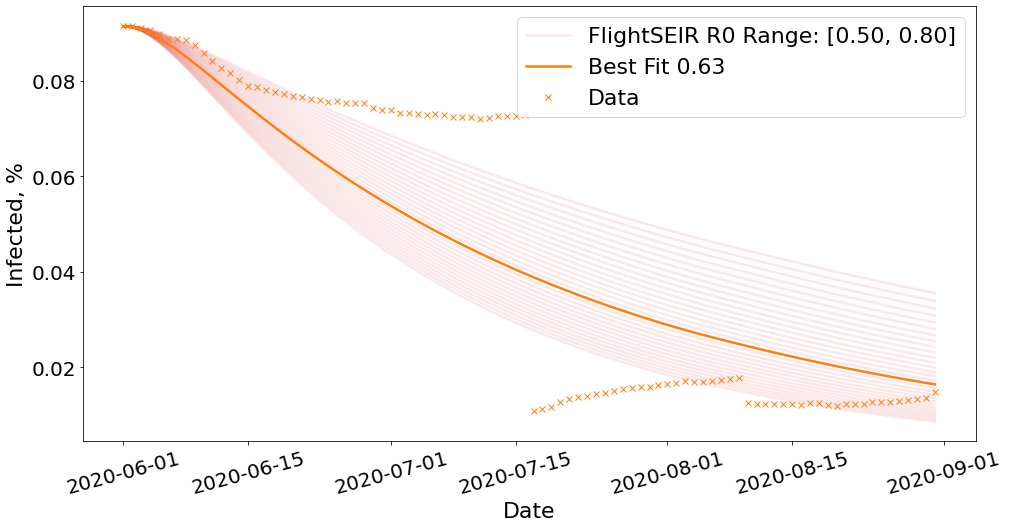

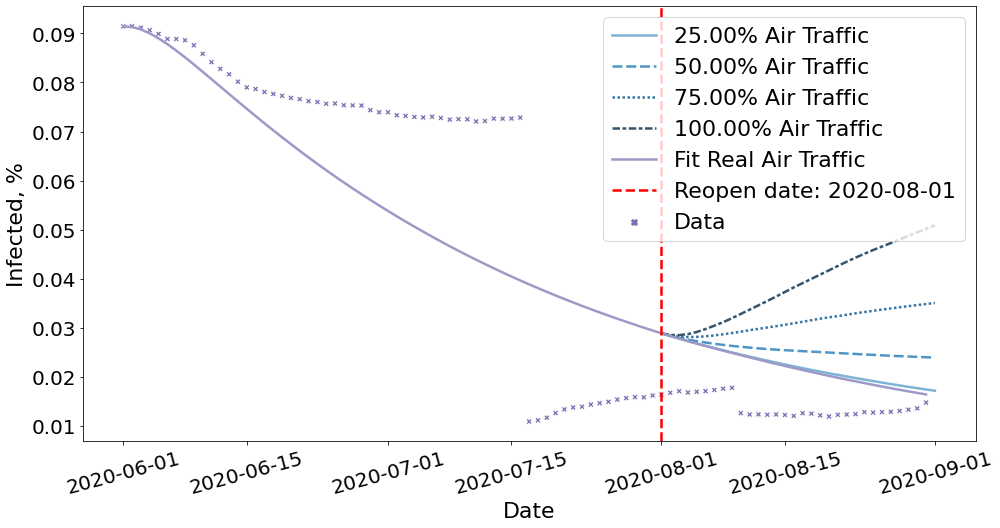

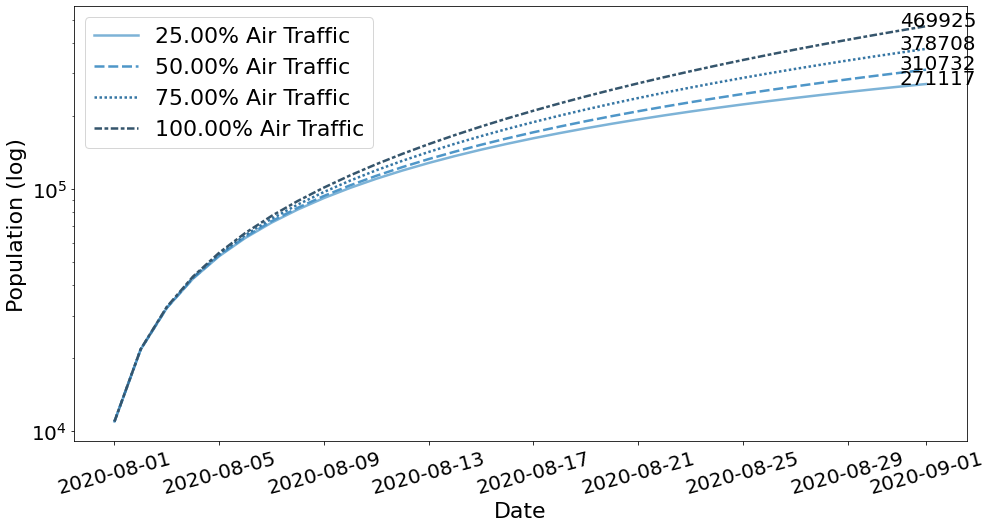

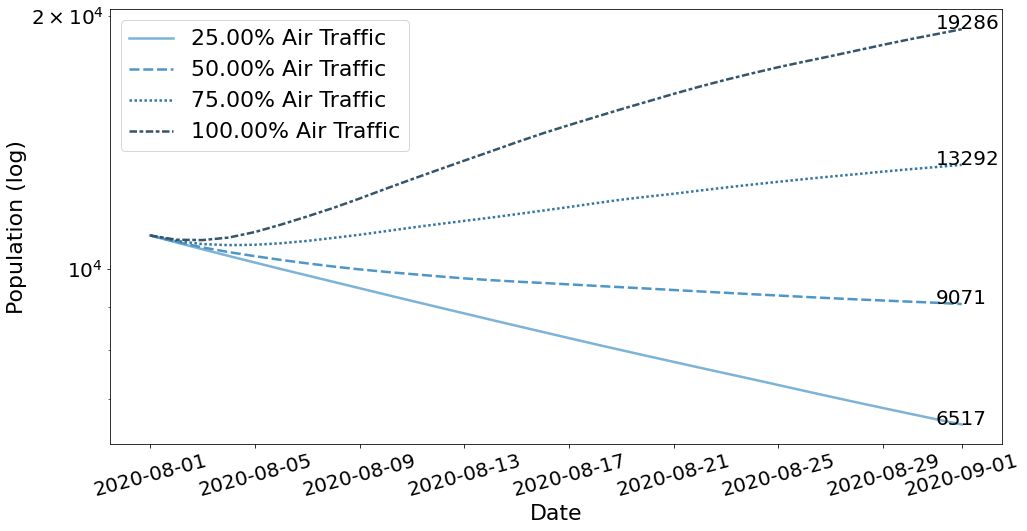

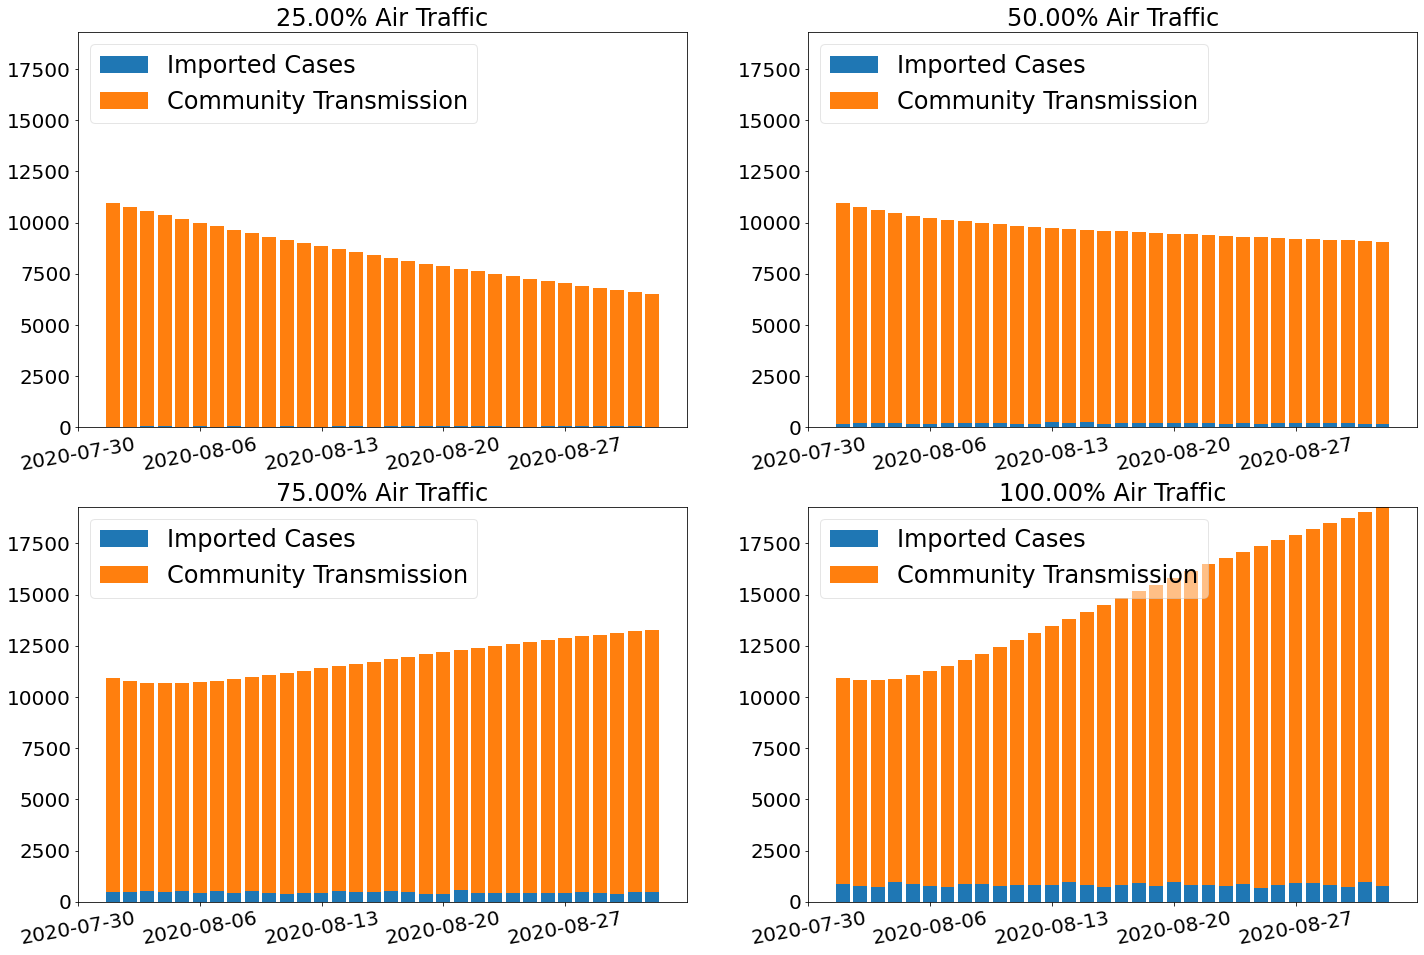

In [320]:
R0_range = np.arange(0.5, 0.8, 0.01)
ReopenSimulation('Canada', 'World', start_date, np.datetime64("2020-09-01")).fit_and_run(R0_range, reopen_date)

(4, 32)


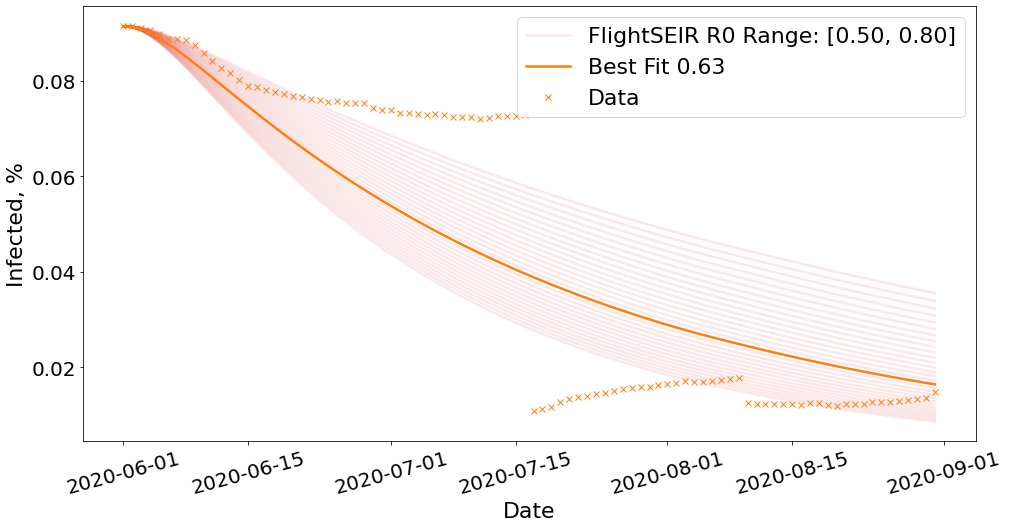

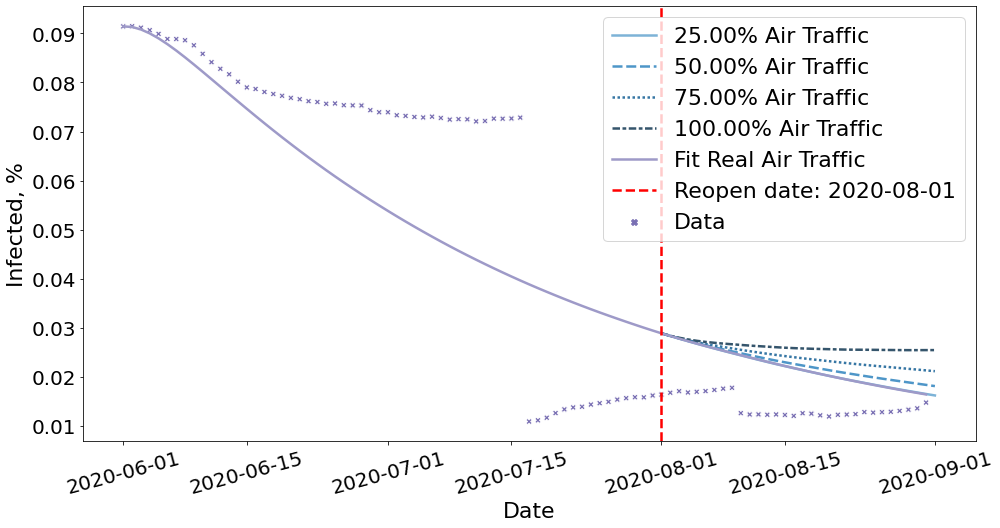

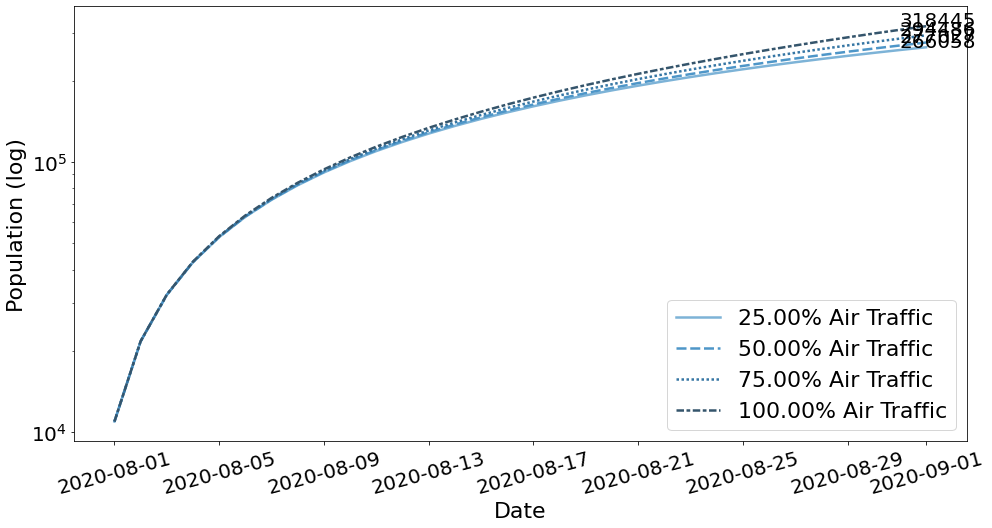

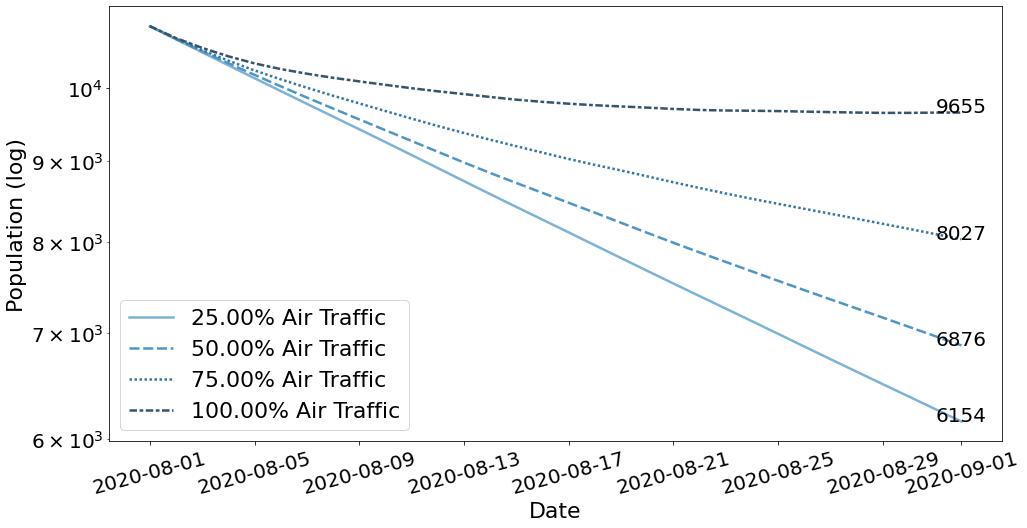

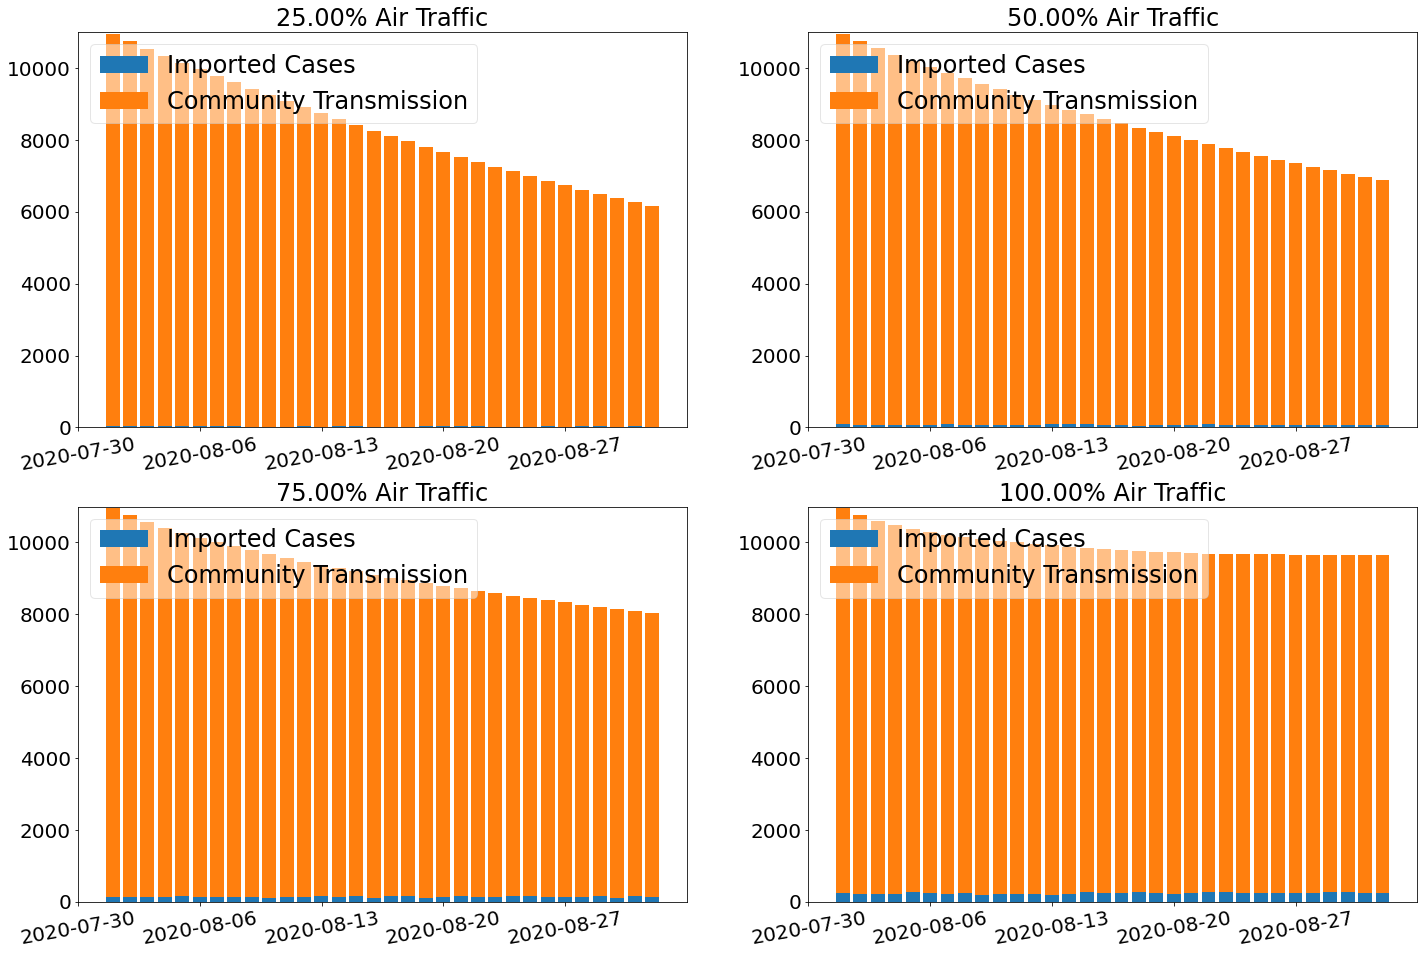

In [321]:
ReopenSimulation('Canada', 'US', start_date, np.datetime64("2020-09-01")).fit_and_run(R0_range, reopen_date)

(4, 32)


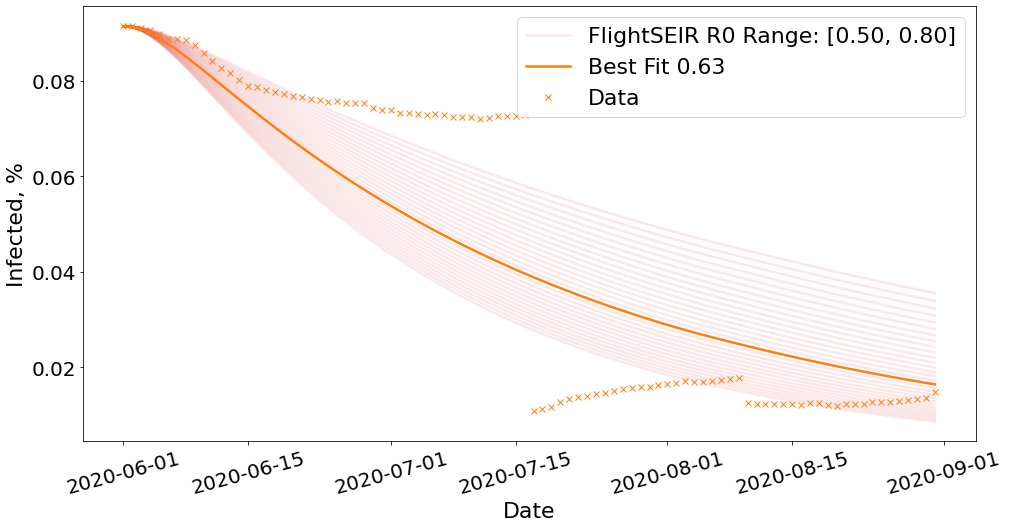

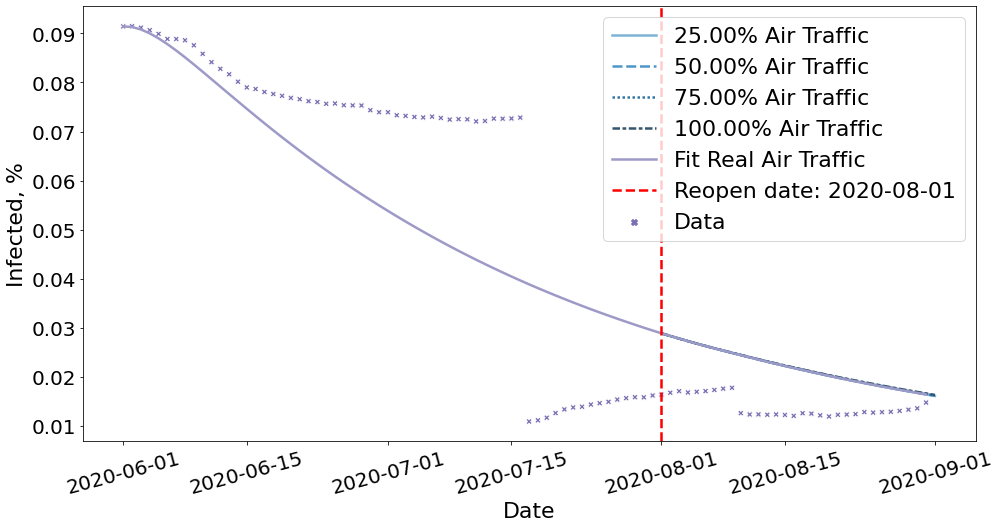

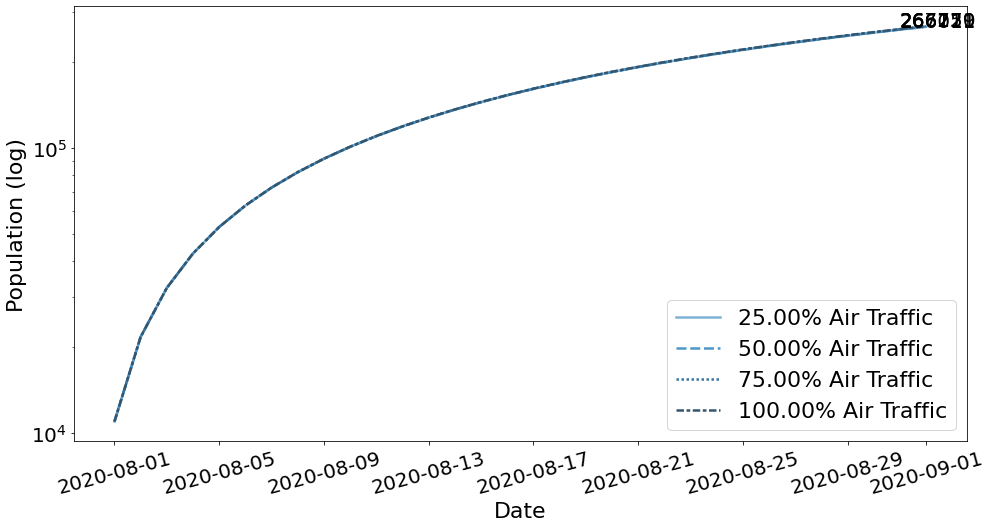

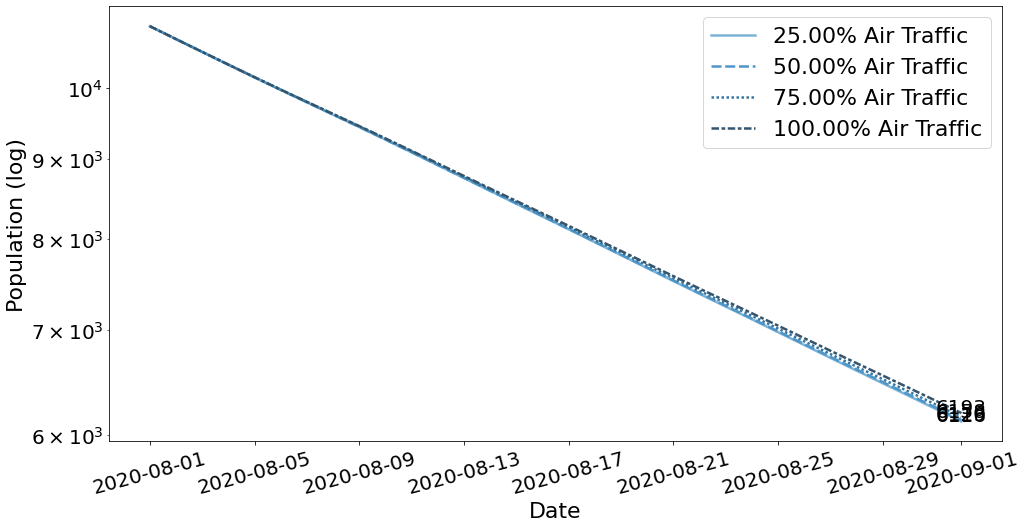

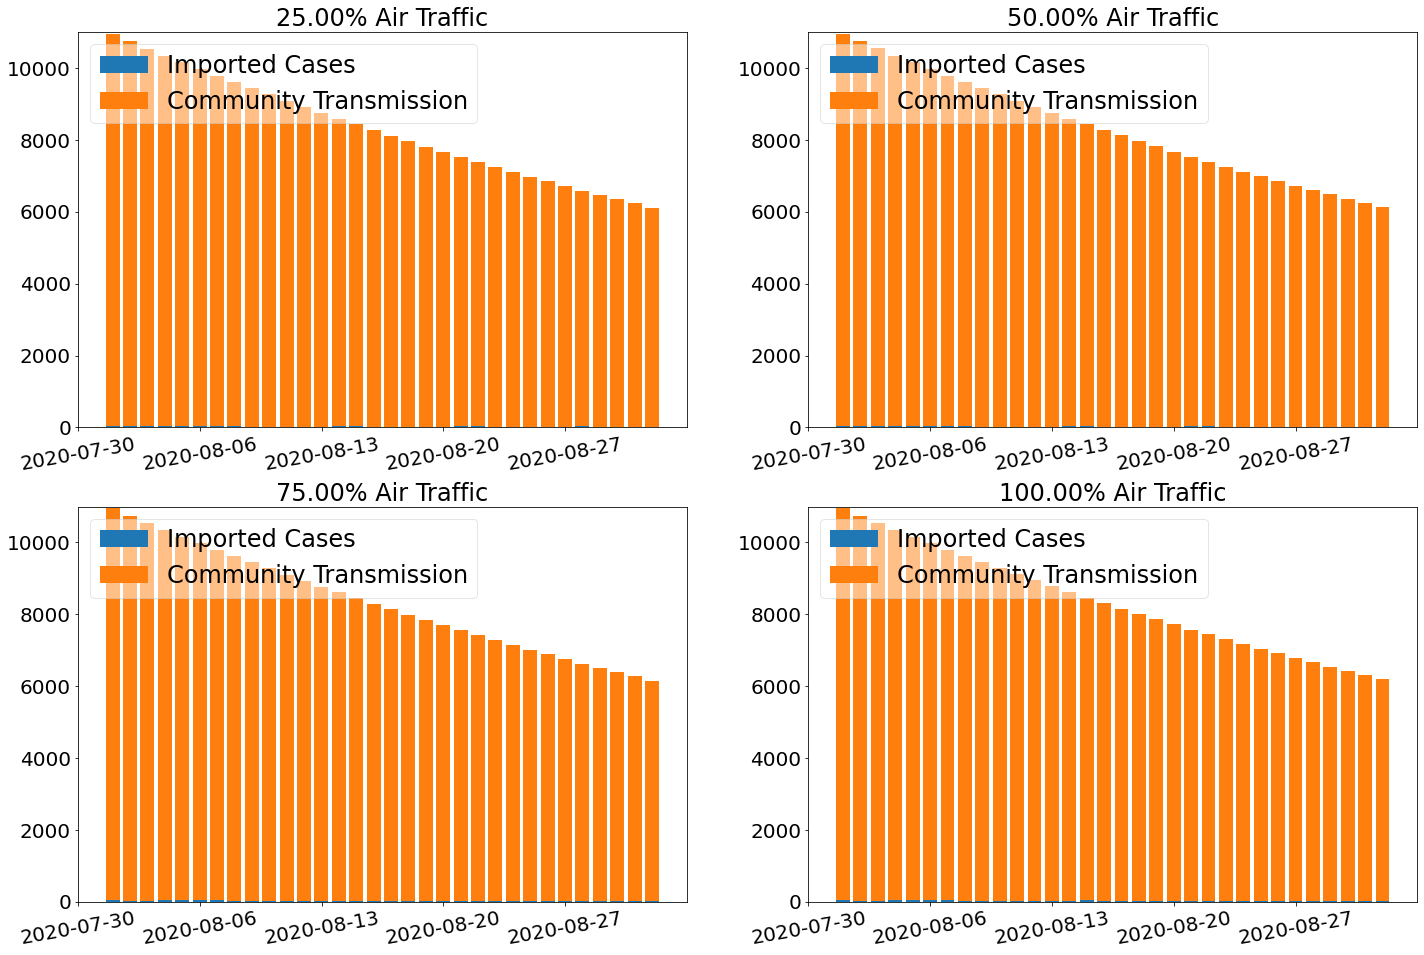

In [322]:
ReopenSimulation('Canada', 'United Kingdom', start_date, np.datetime64("2020-09-01")).fit_and_run(R0_range, reopen_date)

(4, 32)


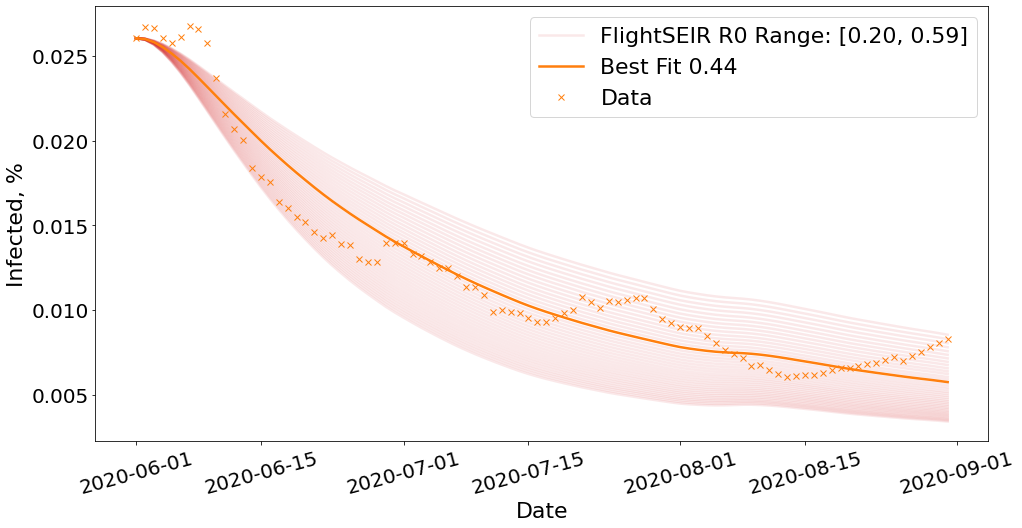

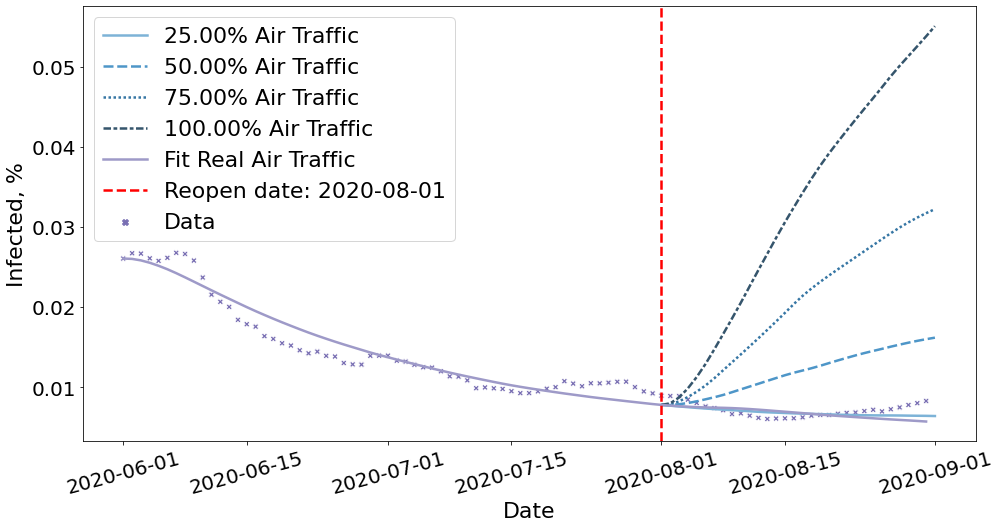

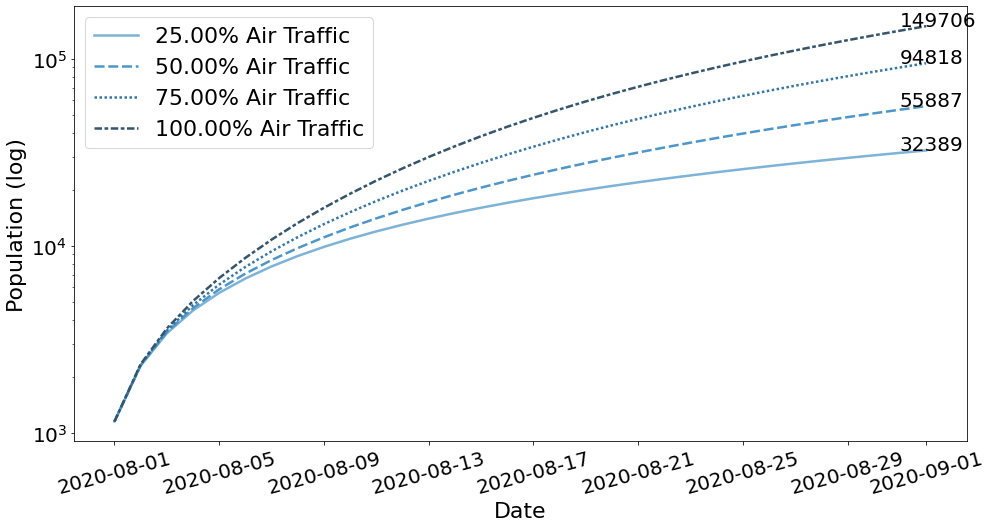

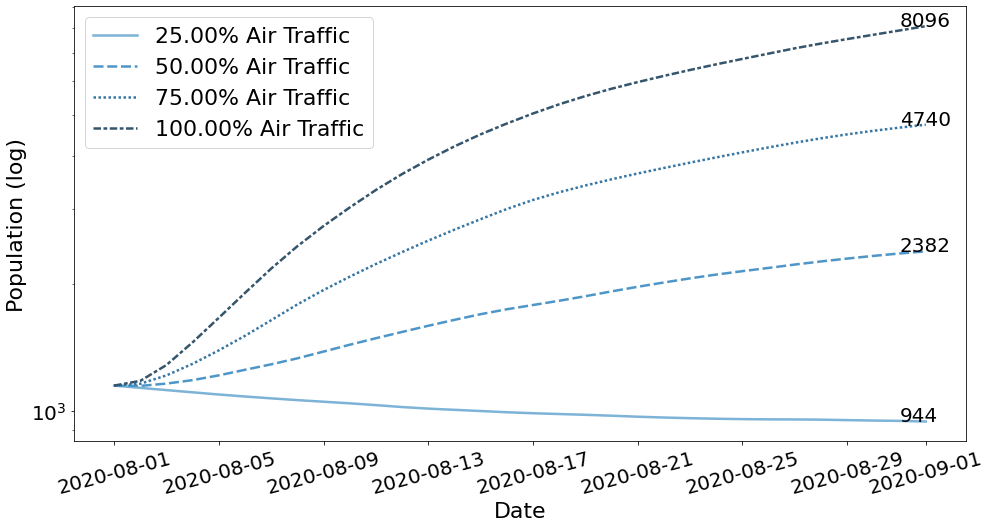

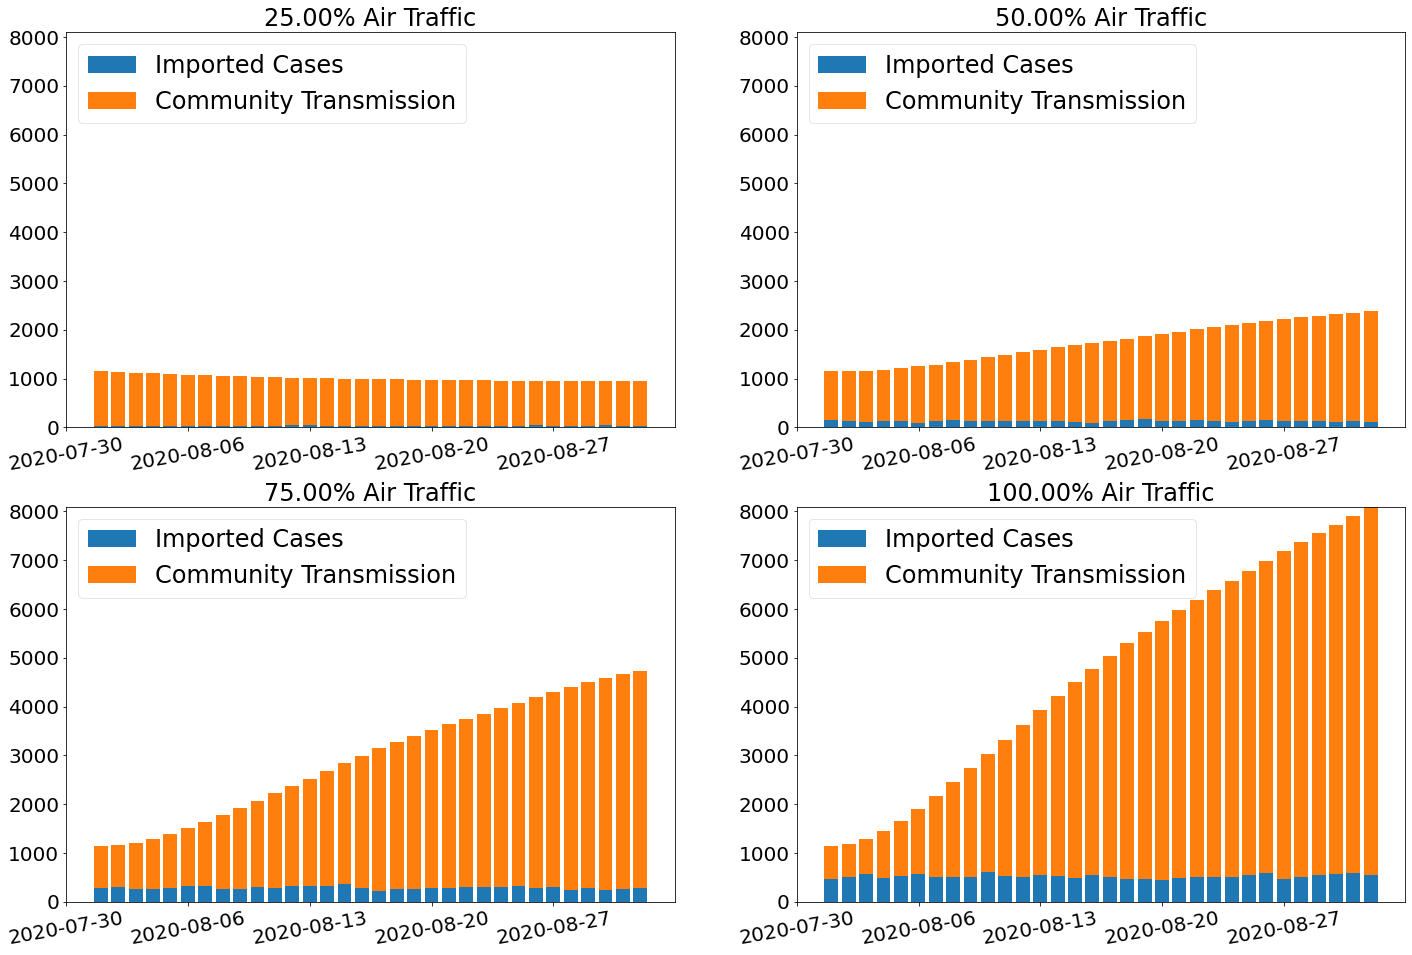

In [323]:
R0_range = np.arange(0.2, 0.6, 0.01)
ReopenSimulation('Ontario', 'World', start_date, np.datetime64("2020-09-01")).fit_and_run(R0_range, reopen_date)

In [324]:
# ReopenSimulation('Ontario', 'US', start_date, np.datetime64("2020-09-01")).fit_and_run(R0_range, reopen_date)

(4, 32)


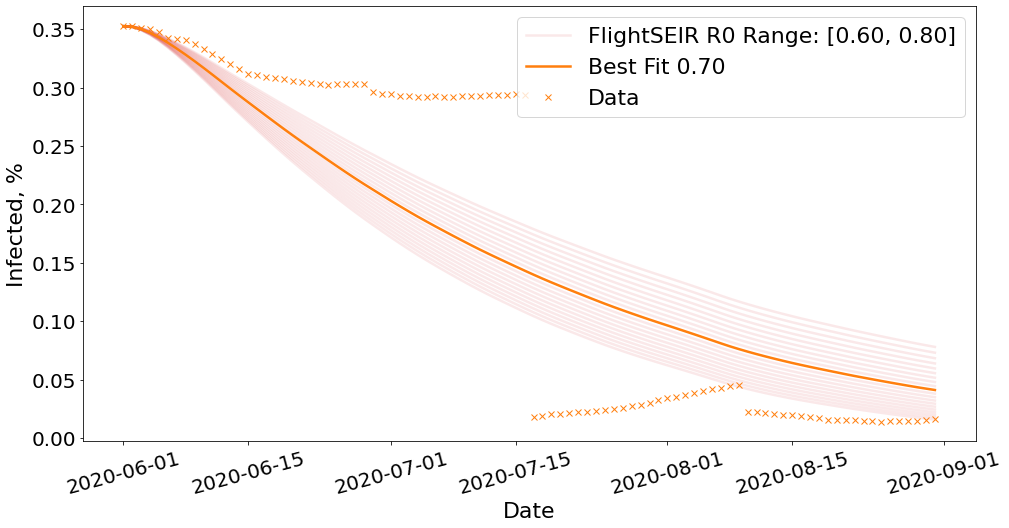

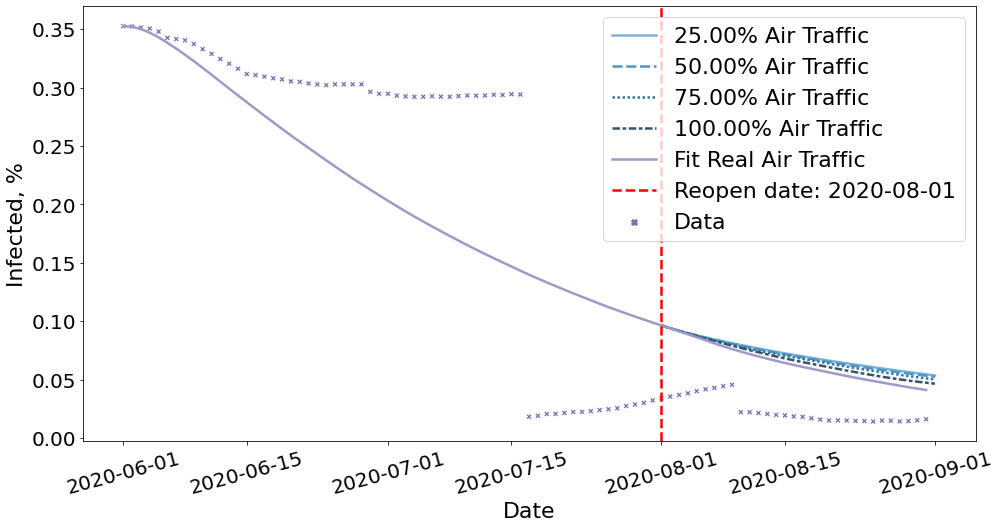

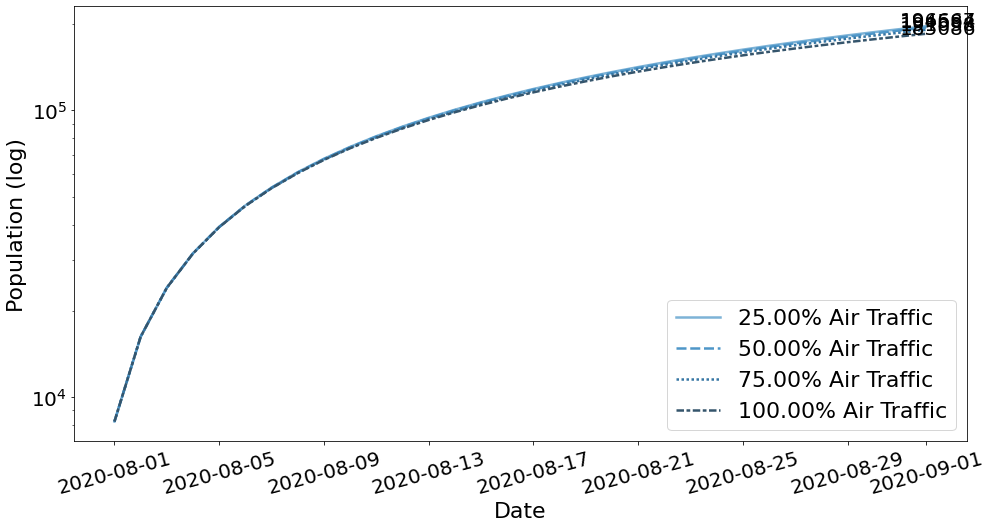

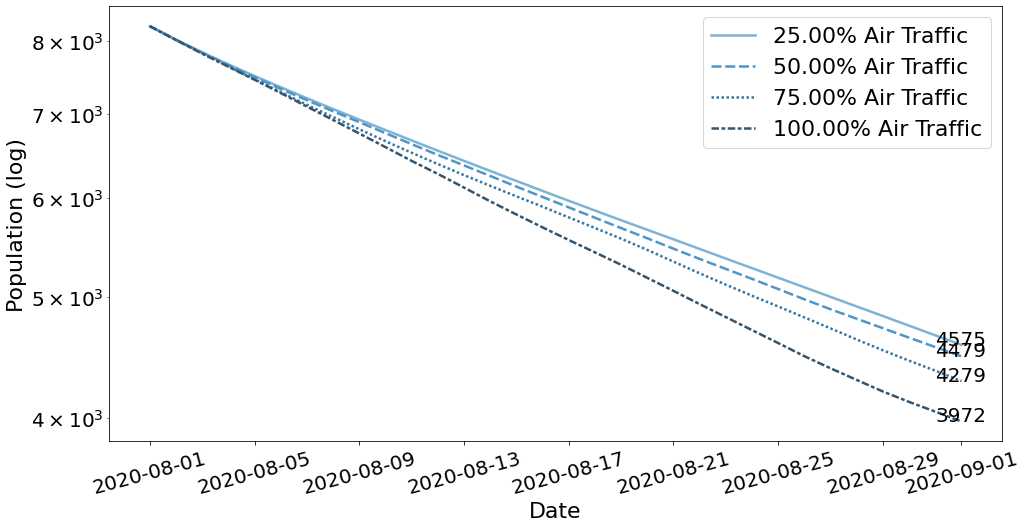

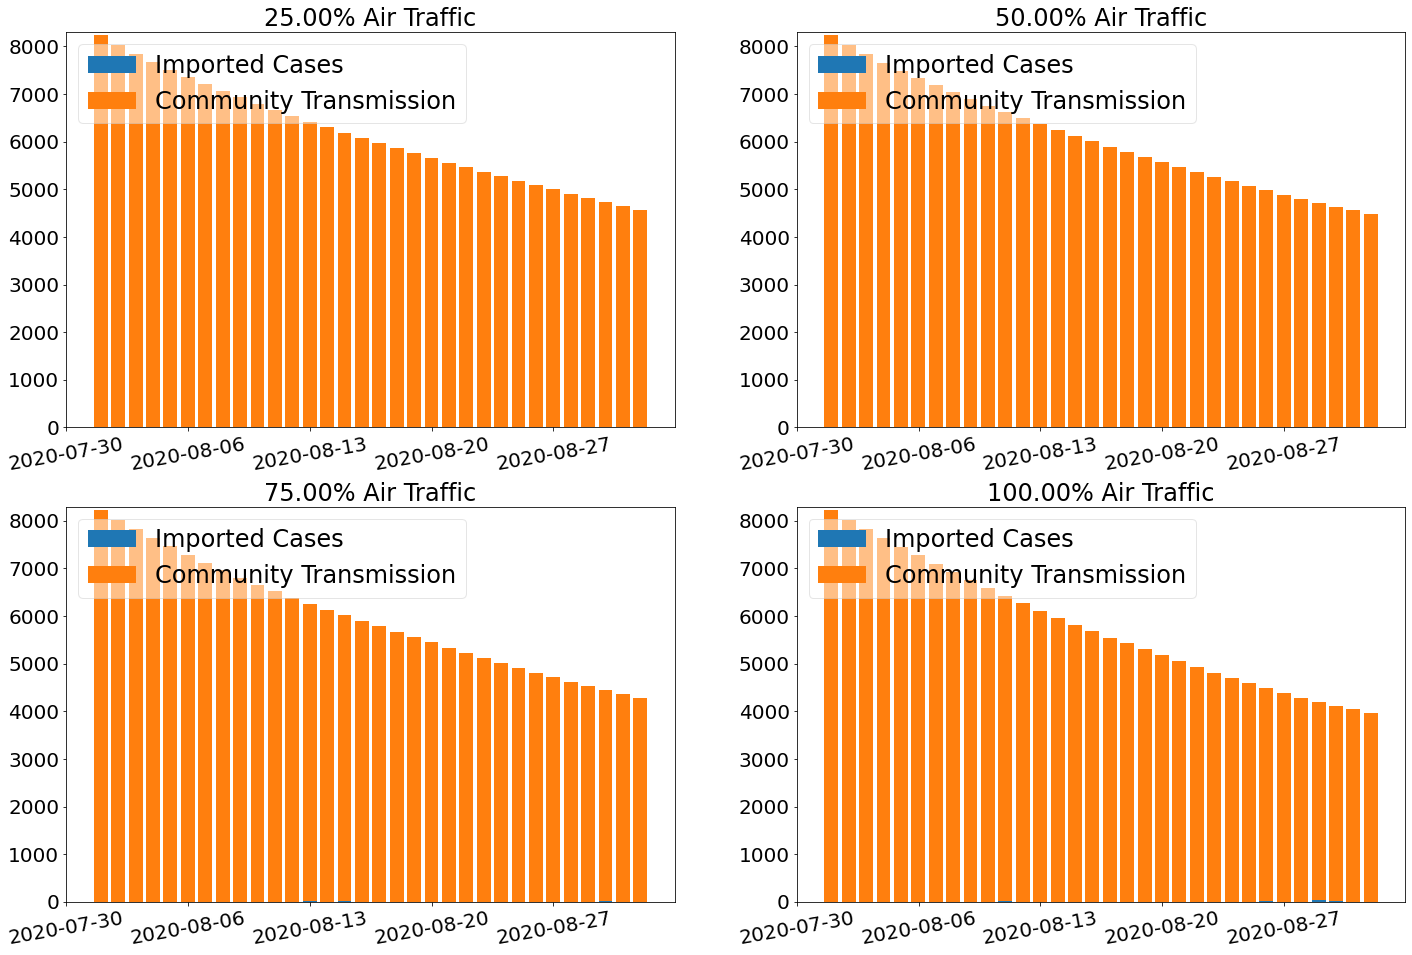

In [325]:
R0_range = np.arange(0.6, 0.8, 0.01)
ReopenSimulation('Quebec', 'World', start_date, np.datetime64("2020-09-01")).fit_and_run(R0_range, reopen_date)

In [326]:
# ReopenSimulation('Quebec', 'US', start_date, np.datetime64("2020-09-01")).fit_and_run(R0_range, reopen_date)

(4, 32)


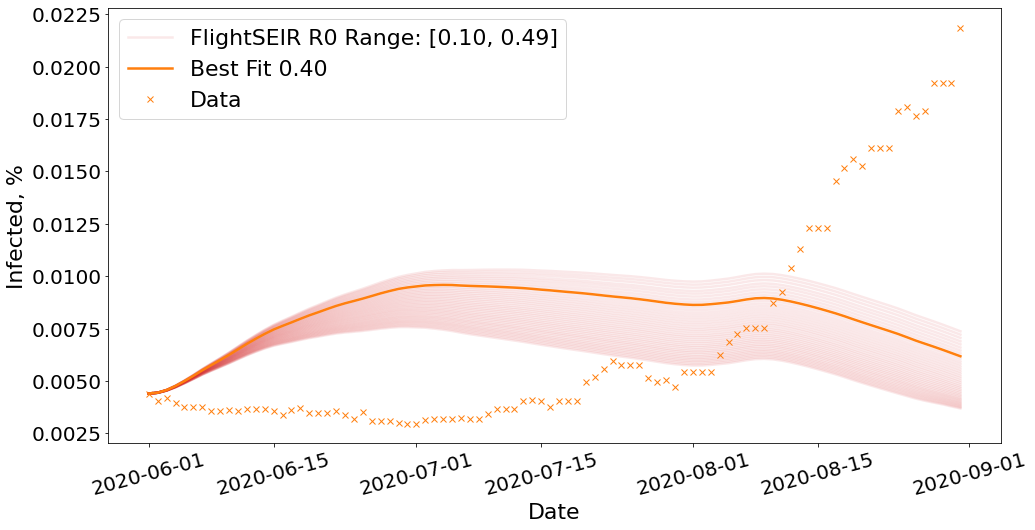

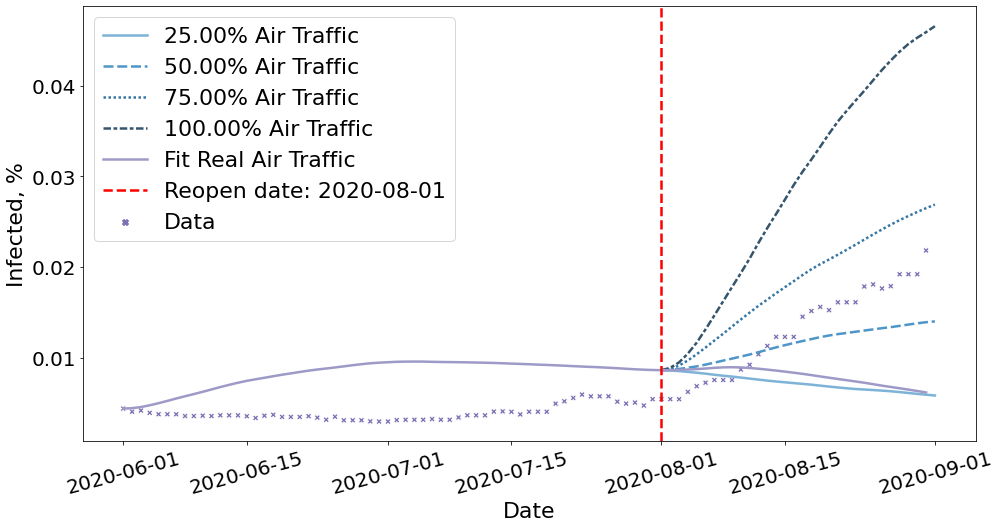

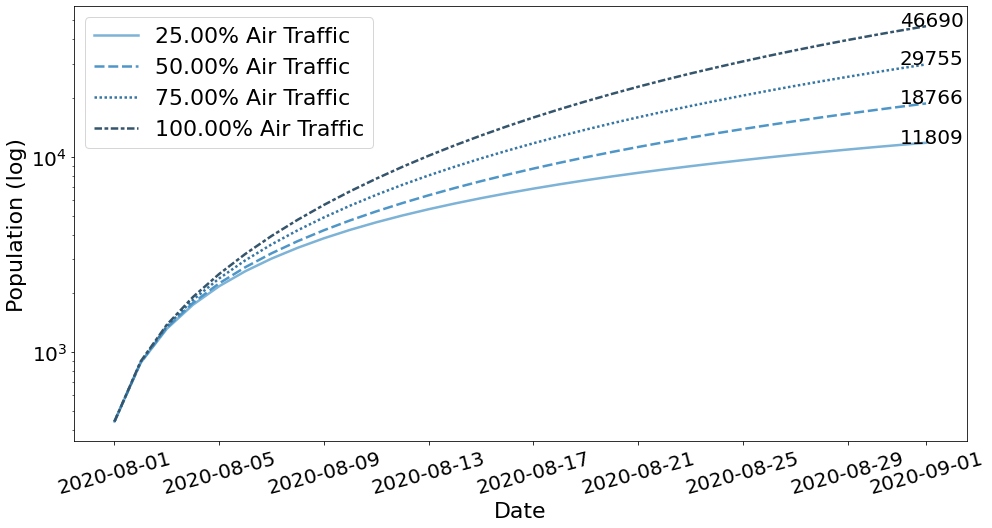

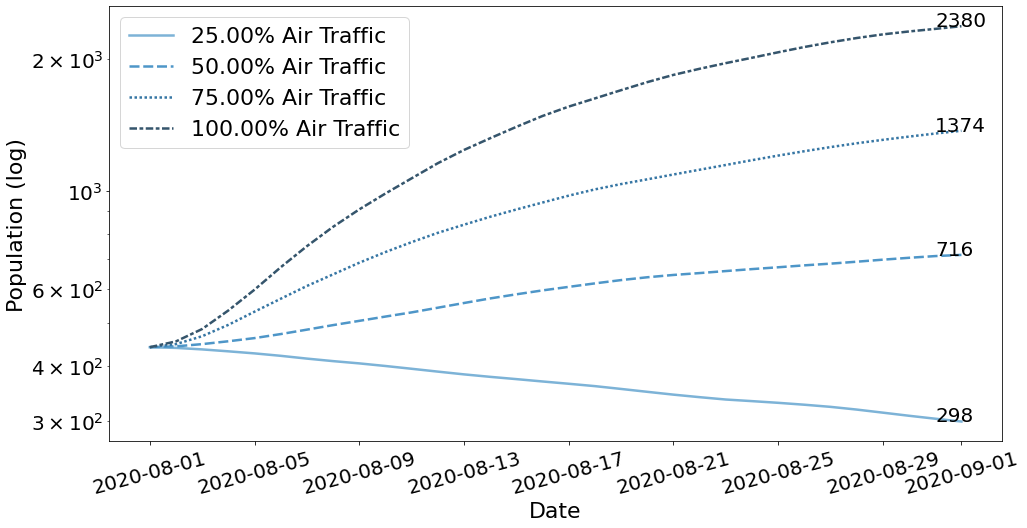

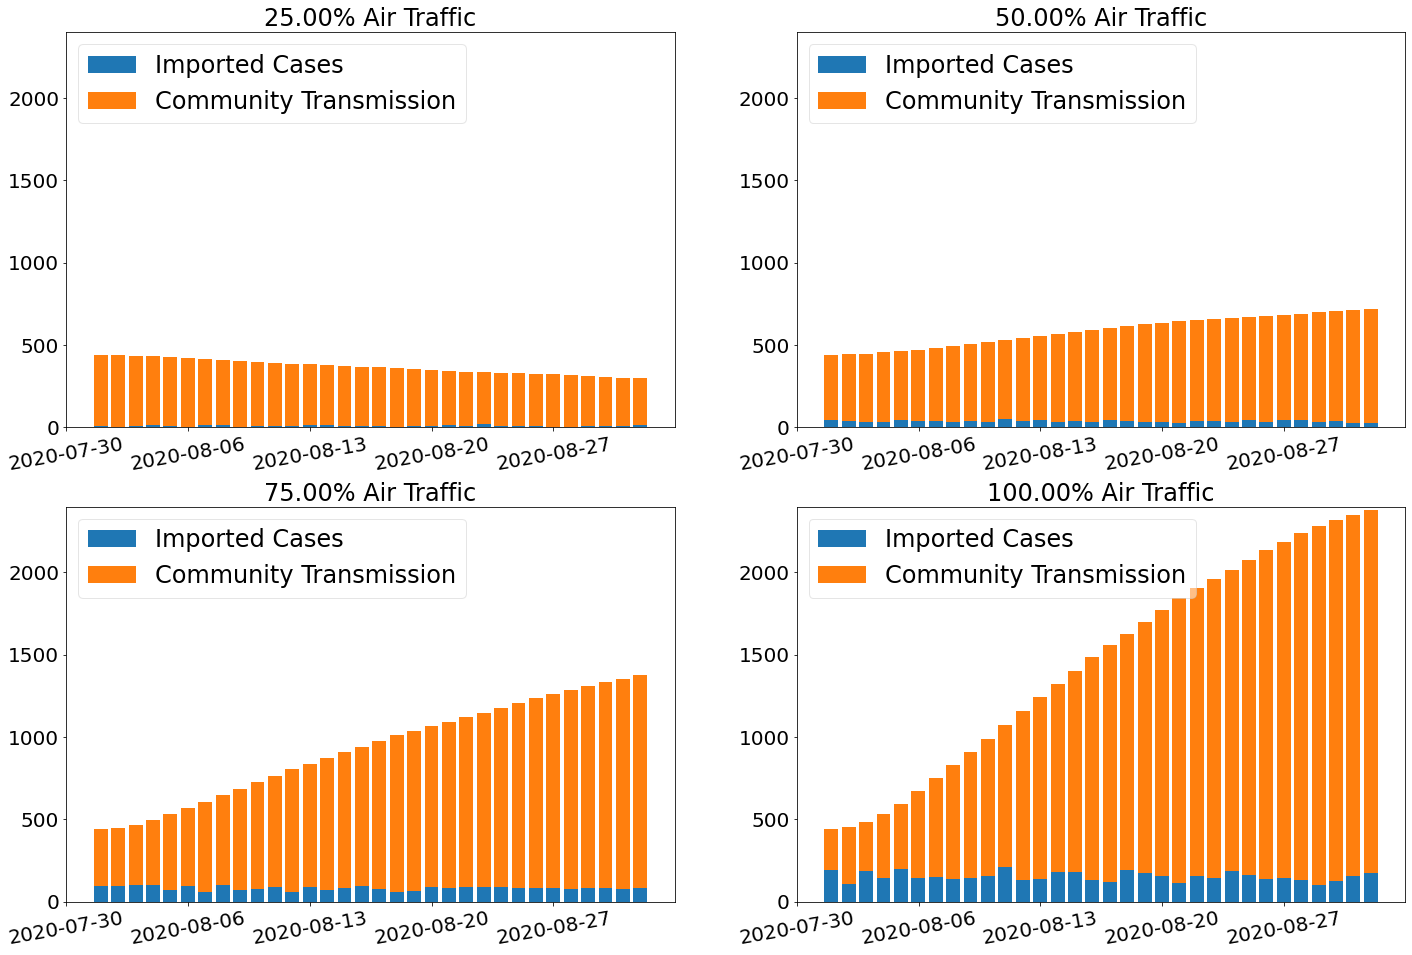

In [327]:
R0_range = np.arange(0.1, 0.5, 0.01)
ReopenSimulation('British Columbia', 'World', start_date, np.datetime64("2020-09-01")).fit_and_run(R0_range, reopen_date)

In [328]:
# ReopenSimulation('British Columbia', 'US', start_date, np.datetime64("2020-09-01")).fit_and_run(R0_range, reopen_date)